In [1]:
import os 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_path= os.path.join(BASE_DIR, "data", "processed", "brent_daily_clean.csv")

df=pd.read_csv(data_path)
df.head()

,date,price
0,1987-05-20,18.630000
1,1987-05-21,18.450000
2,1987-05-22,18.550000
3,1987-05-23,18.566667
4,1987-05-24,18.583333


### Splitting the data into training and validation 

In [3]:
split_idx= int(len(df)*0.8)

train=df.iloc[:split_idx]
val=df.loc[split_idx:]

train.shape, val.shape

((11294, 2), (2824, 2))

### Scaling 

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))

In [5]:
train_scaled=scaler.fit_transform(train[["price"]])
val_scaled=scaler.transform(val[["price"]])

### Sequence Generation and Windowing for LSTM


In [6]:
# Windowing function

def create_sequences (data, window_size=60):
    X,y=[],[]

    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i,0])
        y.append(data[i,0])

    return np.array(X), np.array(y)

In [7]:
# Create train & val sequences

WINDOW_SIZE=60

X_train, y_train= create_sequences(train_scaled, WINDOW_SIZE)
X_val, y_val = create_sequences(val_scaled, WINDOW_SIZE)


X_train.shape, y_train.shape, X_val.shape, y_val.shape

((11234, 60), (11234,), (2764, 60), (2764,))

In [8]:
# Reshape for LSTM

X_train =X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_val=X_val.reshape((X_val.shape[0],X_val.shape[1],1))

X_train.shape, X_val.shape

((11234, 60, 1), (2764, 60, 1))

In [10]:
import tensorflow as tf

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [12]:
model=Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

In [14]:
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train LSTM

history=model.fit(
    X_train, 
    y_train, 
    epochs=20, 
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 0.0021 - val_loss: 6.2941e-04
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - loss: 9.4746e-04 - val_loss: 4.3610e-04
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 8.1068e-04 - val_loss: 4.4763e-04
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - loss: 7.0731e-04 - val_loss: 6.0714e-04
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - loss: 6.7599e-04 - val_loss: 3.9074e-04
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - loss: 6.9401e-04 - val_loss: 4.8743e-04
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 36s 61ms/step - loss: 6.3862e-04 - val_loss: 6.4062e-04
Epoch 9/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 5.8319e-04 - val_loss: 3.7927e-04
Epoch 10/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 5.4659e-04 - val_loss: 3.2929e-04
Epoch 11/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step

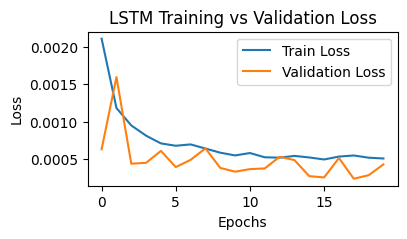

In [18]:
## Plot training vs validation loss

plt.figure(figsize=(4,2))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("LSTM Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [20]:
#Predict on validation
lstm_pred_scaled=model.predict(X_val)


87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [22]:
# Inverse transform predictions & actuals

lstm_pred= scaler.inverse_transform(lstm_pred_scaled)
y_val_actual= scaler.inverse_transform(y_val.reshape(-1,1))

lstm_pred[:5], y_val_actual[:5]


(array([[76.15176],
        [76.36107],
        [76.00348],
        [75.73535],
        [75.50138]], dtype=float32),
 array([[74.25      ],
        [72.87      ],
        [73.67      ],
        [73.38666667],
        [73.10333333]]))

In [24]:
# Evaluate LSTM 

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np 

lstm_mae=mean_absolute_error(y_val_actual,  lstm_pred)
lstm_rmse=np.sqrt(mean_squared_error(y_val_actual, lstm_pred))

lstm_mae, lstm_rmse

(2.140699632672256, np.float64(2.7856220982796174))

### LSTM Model Performance – Conclusion

The LSTM model significantly outperforms both the naive baseline and the ARIMA model, achieving a much lower MAE and RMSE on the validation set.  
This demonstrates the ability of LSTM networks to capture non-linear patterns and volatility present in crude oil price movements.  
The results confirm that deep learning approaches are more suitable than classical time-series models for highly dynamic financial data.


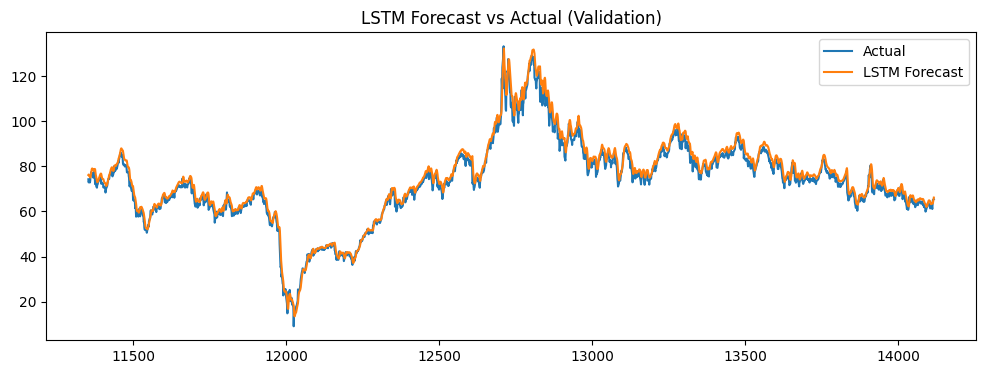

In [29]:
plt.figure(figsize=(12,4))

plt.plot(val.index[WINDOW_SIZE:], y_val_actual, label='Actual')
plt.plot(val.index[WINDOW_SIZE:], lstm_pred, label='LSTM Forecast')

plt.legend()
plt.title("LSTM Forecast vs Actual (Validation)")
plt.show()


In [33]:
model.save("../models/lstm_brent_model.keras")


In [31]:
import joblib

joblib.dump(scaler, "../models/price_scaler.pkl")



['../models/price_scaler.pkl']